In [1]:
import pandas as pd

def expand_and_concat_dicts(df, col):
    """
    Expand a column of dictionaries into separate columns and concatenate with the original dataframe.
    """

    # Expand the column of dictionaries into separate columns
    try:
        expanded_df = pd.DataFrame(df[col].apply(eval).tolist())
    except Exception as e:
        expanded_df = pd.DataFrame(df[col].tolist())
        
    # Rename the columns to avoid duplicates
    expanded_df.columns = [f"{col}_{colname}" for colname in expanded_df.columns]
    
    # Concatenate the expanded dataframe with the original dataframe
    concatenated_df = pd.concat([df, expanded_df], axis=1)
    concatenated_df = concatenated_df.drop(columns=[col])
        
    return concatenated_df

In [2]:
df_prometheus = pd.read_csv('output/samples/en/phase_3/prometheus_evaluation.tsv', sep='\t', dtype={"filenameid": str})
df_prometheus = df_prometheus[["filenameid", "scores"]]
df_llama = pd.read_csv('output/samples/en/phase_3/llama_3B_inst_std_prompt_evaluation.tsv', sep='\t', dtype={"filenameid": str})
df_llama = df_llama[["filenameid", "scores"]]
df_doctor = pd.read_csv('output/samples/en/phase_3/llama_doctor_evaluation.tsv', sep='\t', dtype={"filenameid": str})
df_doctor = df_doctor[["filenameid", "scores"]]
df_gpt = pd.read_csv('output/samples/en/phase_3/gpt4ominihigh_evaluation.tsv', sep='\t', dtype={"filenameid": str})
df_gpt = df_gpt[["filenameid", "scores"]]

cols_eval = ["Medical Entities Completeness", "Structure - Headers", "Structure - Content",	"Content Accuracy",	"Made-up Content",	"Overall Quality"]
df_human = pd.read_csv('output/samples/en/phase_3/human_eval.tsv', sep='\t', dtype={"doc_id": str})
df_human = df_human.rename(columns={"doc_id": "filenameid"})
df_human["scores"] = df_human[cols_eval].apply(lambda x: x.to_dict(), axis=1)
df_human = df_human[["filenameid", "scores", "annotator"]]
df_laura = df_human.loc[df_human["annotator"] == "Laura", ["filenameid", "scores"]].reset_index(drop=True)
df_leti = df_human.loc[df_human["annotator"] == "Leti", ["filenameid", "scores"]].reset_index(drop=True)

df_auto = pd.read_csv('output/samples/en/phase_3/auto_eval.tsv', sep='\t', dtype={"filenameid": str})

print(df_prometheus.shape, df_llama.shape, df_doctor.shape, df_gpt.shape, df_laura.shape, df_leti.shape)

(30, 2) (30, 2) (30, 2) (30, 2) (30, 2) (30, 2)


In [3]:
df_human_uncomp = pd.read_csv('output/samples/en/phase_3/human_eval.tsv', sep='\t', dtype={"doc_id": str})
print(df_human_uncomp.loc[df_human_uncomp["doc_id"].str.startswith("3017"), "Feedback"].values[0])
df_human_uncomp.head()

Diagnosis:** Cutaneous Sarcoidosis (CS).  This is not the diagnosis, it would be  heart failure with AV-block or maybe CS in this case means Cardiac Sarcoidosis 
**FDG-PET Imaging:** Demonstrated high uptake in the basal-anterior wall, supporting the diagnosis of CS. DS  assumes that the diagnosis has been reached with PET when the CC indicates that it has been reached with all the tests performed.


,doc_id,annotator,Key Information CC,Key Information DS,Medical Entities Completeness,Structure - Headers,Structure - Content,Content Accuracy,Made-up Content,Coherence,Overall Quality,Feedback
0,27198691,Laura,"['symptoms, signs and clinical findings', 'dis...","['symptoms, signs and clinical findings', 'dis...",5,5,5,5,5,False,5,The only thing I wanted to comment on is the d...
1,29399767,Laura,"['symptoms, signs and clinical findings', 'dis...","['symptoms, signs and clinical findings', 'dis...",5,5,5,4,4,False,4,The final section Discharge instructions has b...
2,29877258,Laura,"['symptoms, signs and clinical findings', 'dis...","['symptoms, signs and clinical findings', 'dis...",4,5,5,3,1,False,3,There are missing data of some clinical proced...
3,29899452_1,Laura,"['symptoms, signs and clinical findings', 'dis...","['symptoms, signs and clinical findings', 'dis...",4,3,3,3,2,False,2,DS has confused the diagnoses with the medical...
4,30170386,Laura,"['symptoms, signs and clinical findings', 'dis...","['symptoms, signs and clinical findings', 'sex...",5,4,5,4,4,False,2,Diagnosis:** Cutaneous Sarcoidosis (CS). This...


In [4]:
df_sc_prometheus = expand_and_concat_dicts(df_prometheus, "scores")
df_sc_llama = expand_and_concat_dicts(df_llama, "scores")
df_sc_doctor = expand_and_concat_dicts(df_doctor, "scores")
df_sc_gpt = expand_and_concat_dicts(df_gpt, "scores")
df_sc_human_laura = expand_and_concat_dicts(df_laura, "scores")
df_sc_human_leti = expand_and_concat_dicts(df_leti, "scores")

d_dataframes = {
    "auto": df_auto,
    "prometheus": df_sc_prometheus,
    "llama": df_sc_llama,
    "doctor": df_sc_doctor,
    "gpt": df_sc_gpt,
    "Annotator A": df_sc_human_laura,
    "Annotator B": df_sc_human_leti,
    "leti": df_sc_human_leti,
}

In [18]:
# from sklearn.metrics import spearmanr
from scipy.stats import spearmanr
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


ls_cols = df_sc_human_laura.columns.tolist()
ls_cols.remove("filenameid")

def compute_corr(auto_name, name2, auto_col="f1", **kwargs):
    df1 = d_dataframes[auto_name]
    df2 = d_dataframes[name2]
    d_out = {}
    for col in ls_cols:
        suf_1 = "_" + name1
        suf_2 = "_" + name2
        df_total = df1.merge(df2, on="filenameid")
        rho = spearmanr(df_total[auto_col].values, df_total[col].values, **kwargs)
        # print(f"cohen_kappa_score {col} Laura vs GPT: {kappa:.2f}")
        d_out[col] = rho.statistic
    return d_out

# def compute_agreement(name1, name2, field):
    
#     df_agreement = pd.DataFrame(np.zeros((5,5)), columns=list(range(1, 6)), index=list(range(1, 6)), dtype=int)
    
#     df1 = d_dataframes[name1]
#     df2 = d_dataframes[name2]
    
#     # for col in ["scores_Medical Entities Completeness"]:
#     suf_1 = "_" + name1
#     suf_2 = "_" + name2
#     df_total = df1.merge(df2, on="filenameid", suffixes=(suf_1, suf_2))
#     for idx, row in df_total.iterrows():
#         val1 = row[field + suf_1]
#         val2 = row[field + suf_2]
#         df_agreement.loc[val1, val2] += 1
            
#     return df_agreement

# def distance(x, y):
#     return abs(int(x) - int(y))

# def compute_multi_kappa(d_dataframes, ls_names, ls_fields, distance=None):
    
#     """
#     Compute the multi-kappa for a list of annotators.
#     """
#     d_out = {}
#     for field in ls_fields:
#         data = []
#         for name in ls_names:
#             df1 = d_dataframes[name].copy()
#             df1.sort_values(by="filenameid", inplace=True)
#             ls_ann1 = [(name, row["filenameid"], str(row[field])) for _, row in df1.iterrows()]
#             data.extend(ls_ann1)
#         # print(data)
#         ann_task = AnnotationTask(data=data) if distance is None else AnnotationTask(data=data, distance=distance)
#         d_out[field] = ann_task.multi_kappa()
            
#     return d_out

def plot_heatmap(df, ax, vmin=-1, vmax=1, title=None, xlabel=None, y_label=None, figsize=(5, 5), fmt=".2f"):

    # Create a heatmap using seaborn
    plt.figure(figsize=figsize)
    sns.heatmap(df, annot=True, fmt=fmt, cmap="coolwarm", cbar=True, vmin=vmin, vmax=vmax,ax=ax);

    if title is not None:
        ax.set_title(title);
    if xlabel is not None:
        ax.set_xlabel(xlabel);
    if y_label is not None:
        ax.set_ylabel(y_label);
 
d_df_auto = {}       
ls_names = ["Annotator A", "Annotator B", "gpt", "llama", "doctor", "prometheus"]
ls_auto_metrics = ["f1", "precision", "recall"]

for auto_col in ls_auto_metrics:
    d_corr = {}
    name1 = "auto"
    for name2 in ls_names:
        d_corr[name2] = compute_corr(name1, name2, auto_col=auto_col)

    df_i = pd.DataFrame(d_corr)
    df_i.index = df_i.index.str.replace("scores_", "", regex=False)
    
    d_df_auto[auto_col] = df_i
    

d_df_auto["precision"]

,Annotator A,Annotator B,gpt,llama,doctor,prometheus
Medical Entities Completeness,0.647942,0.581631,0.601089,-0.239303,0.088791,-0.038727
Structure - Headers,0.253397,0.389497,0.203451,-0.113291,0.056509,0.044601
Structure - Content,0.543925,0.532825,-0.247023,-0.201507,-0.173363,0.223166
Content Accuracy,0.530290,0.579255,0.214839,-0.196528,-0.099943,0.012053
Made-up Content,0.253674,0.565126,0.217646,-0.281530,0.007013,-0.053635
Overall Quality,0.231357,0.447871,0.511351,-0.256318,-0.129599,0.079015


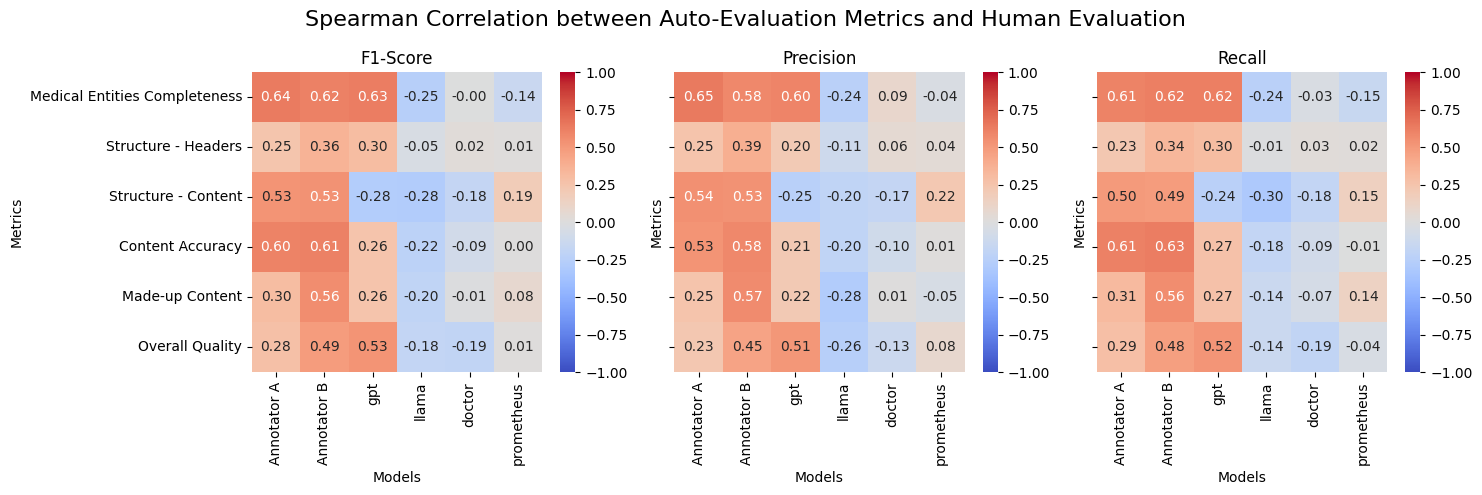

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

plot_heatmap(d_df_auto["f1"], ax[0], vmin=-1, vmax=1, title="F1-Score", xlabel="Models", y_label="Metrics", fmt=".2f")
plot_heatmap(d_df_auto["precision"], ax[1], vmin=-1, vmax=1, title="Precision", xlabel="Models", y_label="Metrics", fmt=".2f")
plot_heatmap(d_df_auto["recall"], ax[2], vmin=-1, vmax=1, title="Recall", xlabel="Models", y_label="Metrics", fmt=".2f")
fig.suptitle("Spearman Correlation between Auto-Evaluation Metrics and Human Evaluation", fontsize=16)

fig.tight_layout()
fig.savefig("img/results_analysis/heatmap_auto_agreement.png")

In [8]:
ls_names

['Annotator A', 'Annotator B', 'gpt', 'llama', 'doctor', 'gpt', 'prometheus']

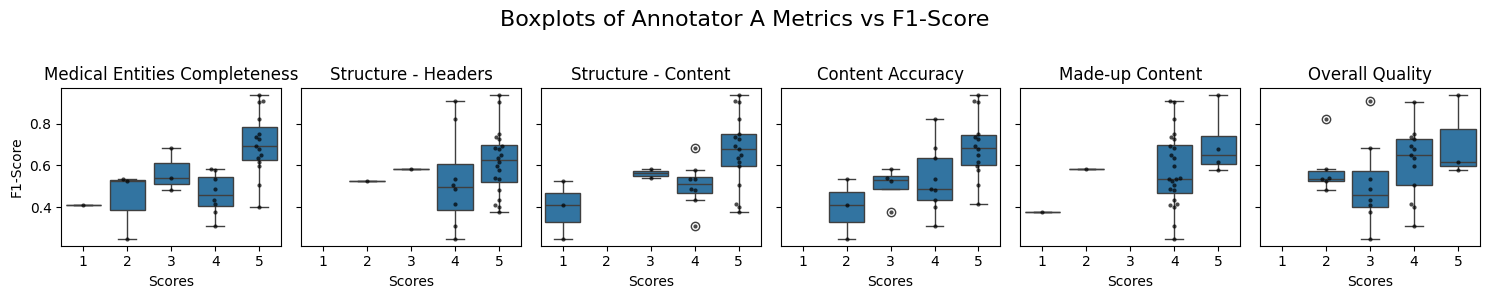

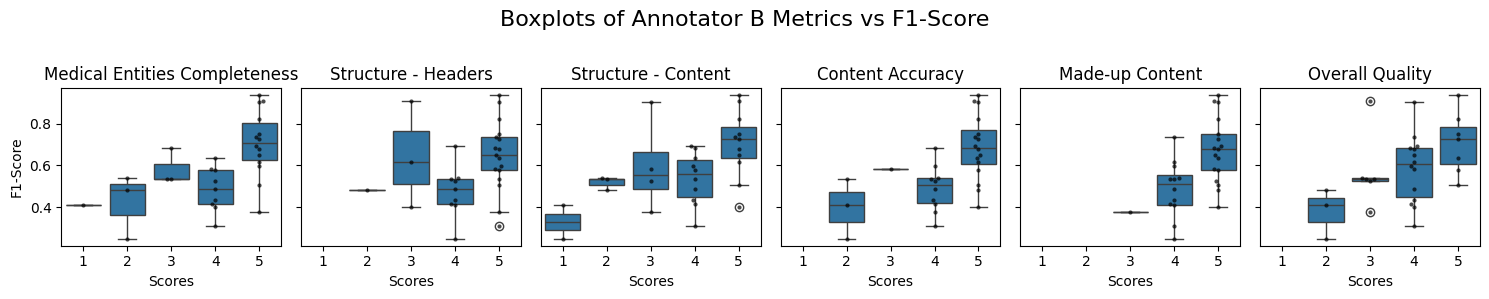

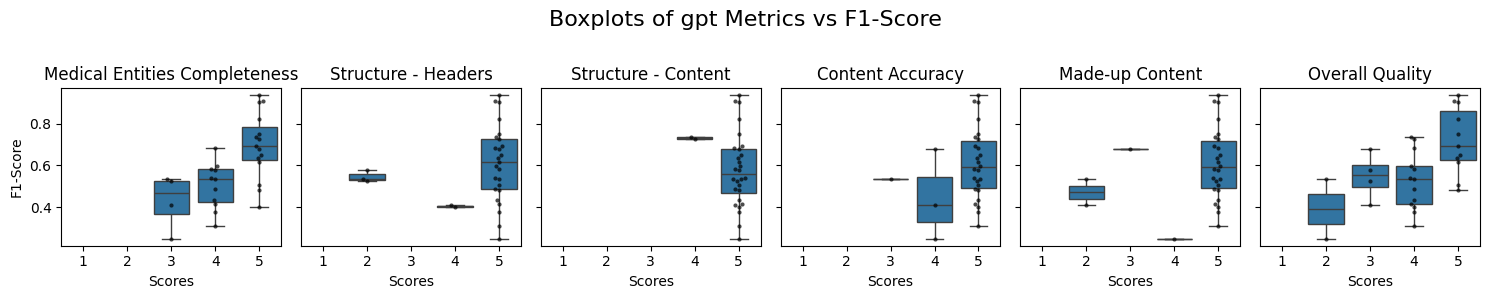

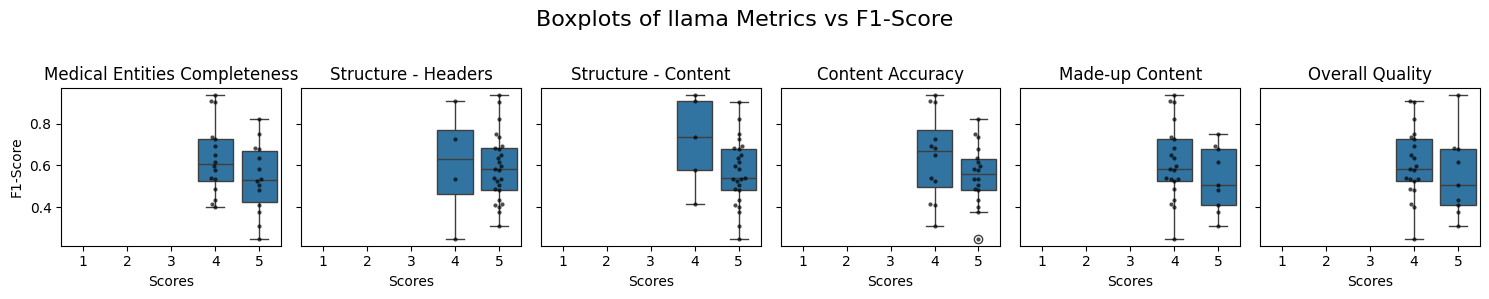

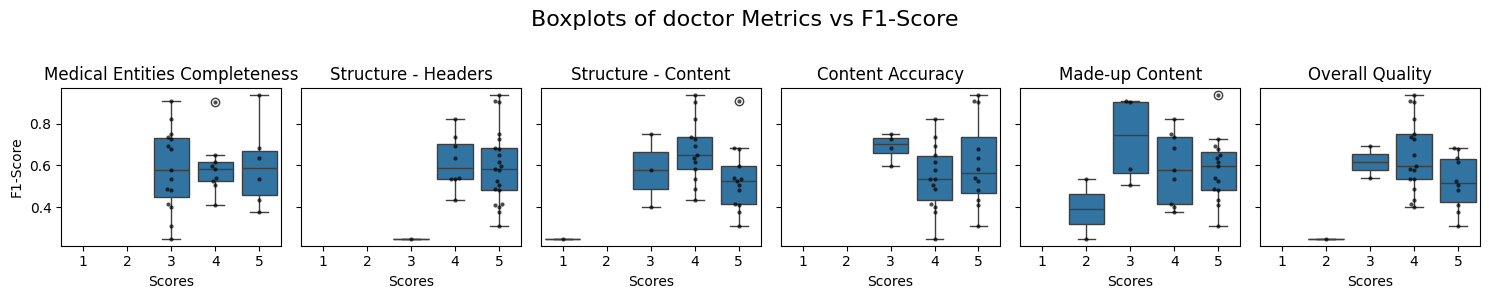

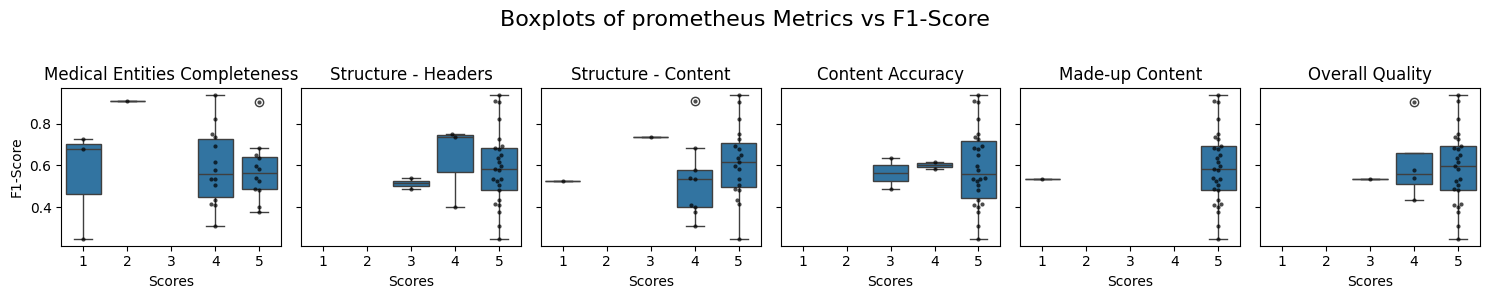

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_auto_vs_human(name, ls_cols, df_auto, d_dataframes):
    # merge the automated and human data
    df_tot_aux = df_auto.merge(d_dataframes[name], on="filenameid")

    # figure grid setup
    n_cols = 6
    n_rows = len(ls_cols) // n_cols + int(len(ls_cols) % n_cols != 0)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 3), sharey=True, sharex=True)
    axes = ax if n_rows == 1 else ax.flatten()
    # axes = ax.flatten() if n_rows > 1 else [ax]
    
    order = [1, 2, 3, 4, 5]
    # loop over each metric column
    for i, col in enumerate(ls_cols):
        
        sns.boxplot(x=df_tot_aux.sort_values(by=col)[col].astype(int), 
                    y=df_tot_aux.sort_values(by=col)["f1"], 
                    ax=axes[i], order=order,)
        sns.swarmplot(x=df_tot_aux.sort_values(by=col)[col].astype(int), 
                      y=df_tot_aux.sort_values(by=col)["f1"],
                      dodge=True, alpha=0.7, color='black', ax=axes[i], order=order, marker='o', size=3)

        # titles and labels
        axes[i].set_title(col.split("_")[-1])
        axes[i].set_xlabel("Scores")
        axes[i].set_ylabel("F1-Score")

    fig.suptitle(f"Boxplots of {name} Metrics vs F1-Score", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    # save
    fig.savefig(f"img/results_analysis/boxplot_auto_vs_human_{name}.png")
    # plt.close(fig)
    fig.show()

# Boxplots for each model
for name in ls_names:
    boxplot_auto_vs_human(name, ls_cols, df_auto, d_dataframes)

In [ ]:
field = "scores_Medical Entities Completeness"

def plot_agreement_heatmap(annotator, field, figsize):
    df_ag_ann_gpt = compute_agreement(annotator, "gpt", field)
    df_ag_ann_llama = compute_agreement(annotator, "llama", field)
    df_ag_ann_doctor = compute_agreement(annotator, "doctor", field)
    df_ag_ann_prometheus = compute_agreement(annotator, "prometheus", field)

    # Plot both in a subplot
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    axs = axs.flatten()
    plot_heatmap(df_ag_ann_gpt, vmin=0, vmax=30, xlabel="GPT", y_label=annotator, title=f"{annotator} vs GPT", fmt=".0f", ax=axs[0]);
    plot_heatmap(df_ag_ann_llama, vmin=0, vmax=30, xlabel="Llama", y_label=annotator, title=f"{annotator} vs Llama 3.2 3B Inst", fmt=".0f", ax=axs[1]);
    plot_heatmap(df_ag_ann_doctor, vmin=0, vmax=30, xlabel="Doctor", y_label=annotator, title=f"{annotator} vs Llama Doctor", fmt=".0f", ax=axs[2]);
    plot_heatmap(df_ag_ann_prometheus, vmin=0, vmax=30, xlabel="Prometheus", y_label=annotator, title=f"{annotator} vs Prometheus 2", fmt=".0f", ax=axs[3]);

    field_name = field.split("_")[1]
    fig.suptitle(field_name, fontsize=16)
    fig.tight_layout();

    field_name_filename = field_name.replace(" ", "_").replace("-", "_")
    annotator_filename = annotator.replace(" ", "_").replace("-", "_")
    fig.savefig(f"img/results_analysis/heatmap_agreement_{annotator_filename}_{field_name_filename}.png", dpi=300, bbox_inches='tight')
    


/scratch/tmp/ipykernel_4126149/3373706943.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 2, figsize=figsize)


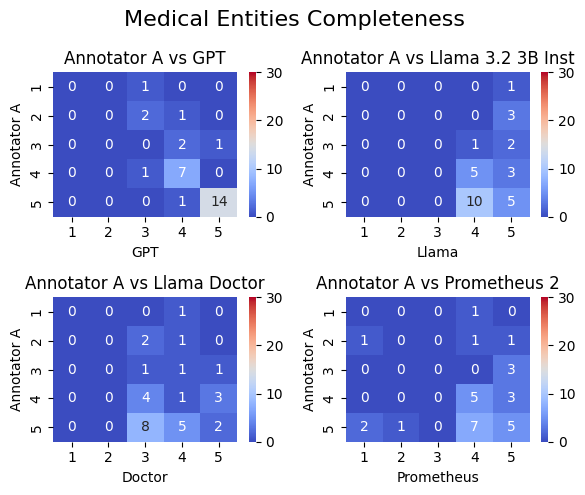

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

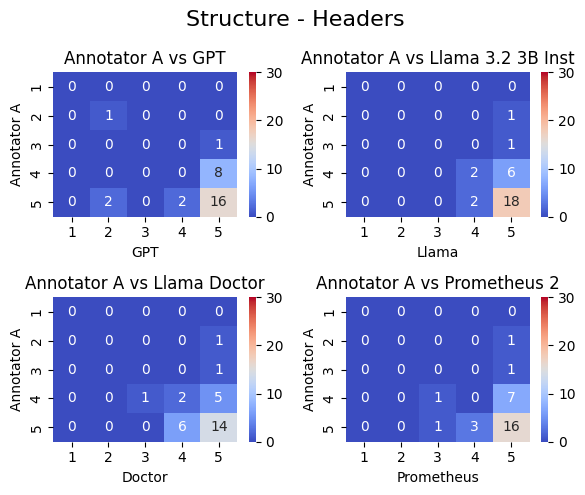

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

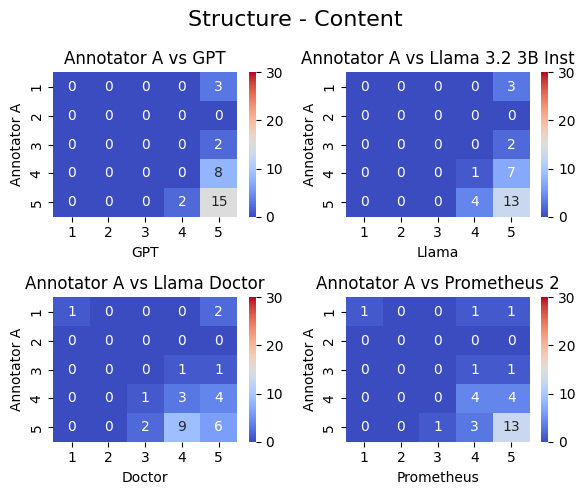

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

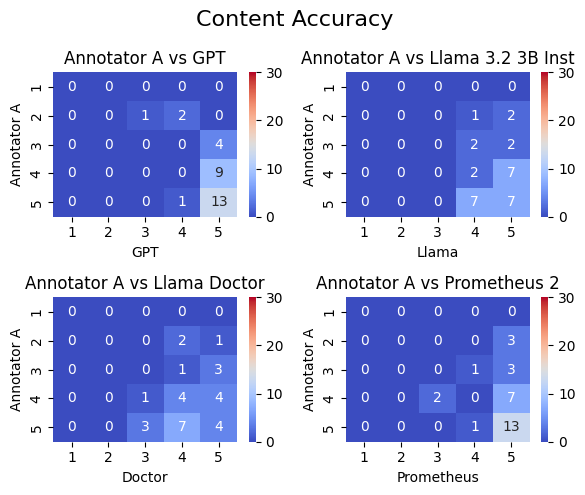

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

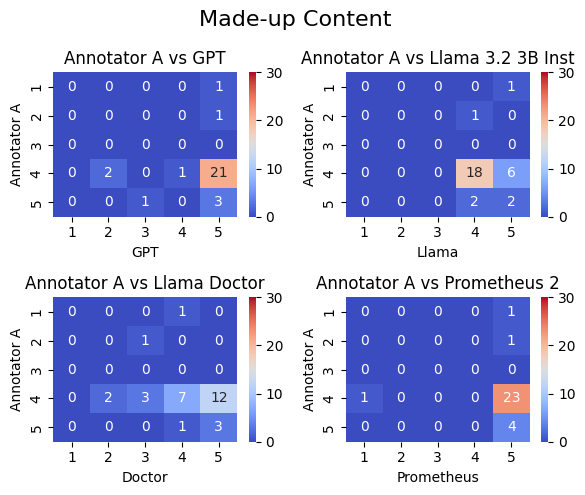

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

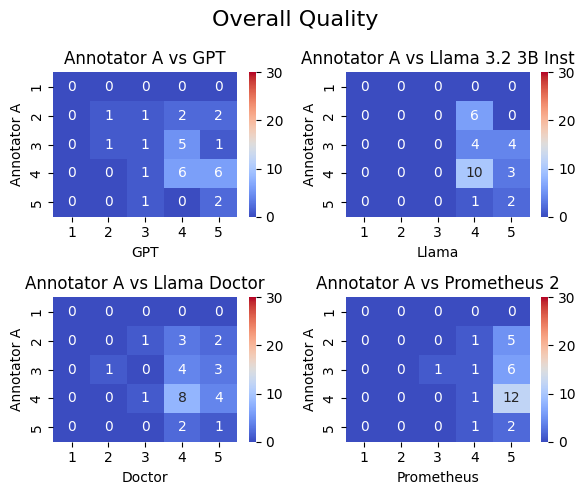

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [8]:
ls_cols = df_sc_human_laura.columns.tolist()
ls_cols.remove("filenameid")

annotator = "Annotator A"

for col in ls_cols:
    plot_agreement_heatmap(annotator, col, figsize=(6, 5))

/scratch/tmp/ipykernel_4126149/3373706943.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 2, figsize=figsize)


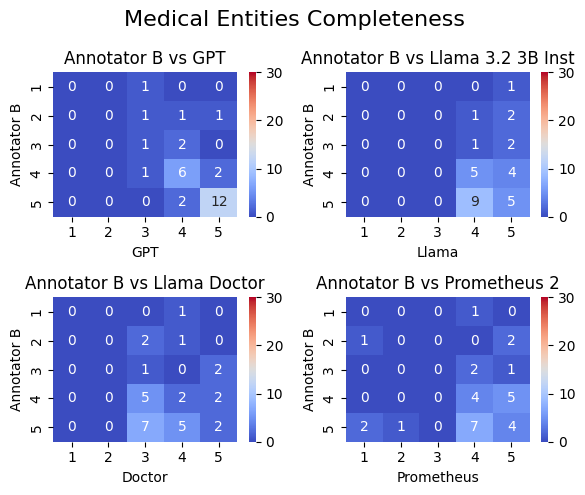

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

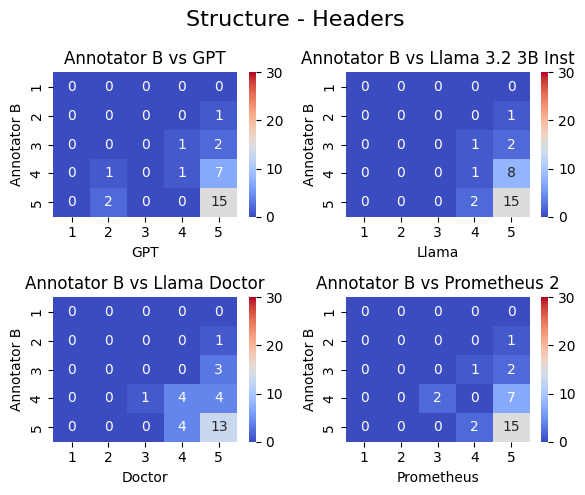

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

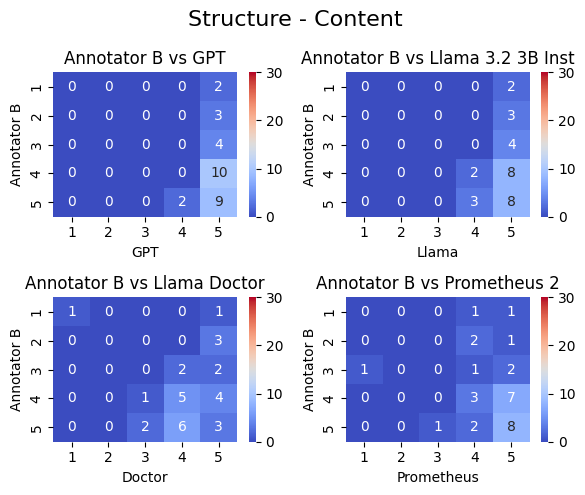

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

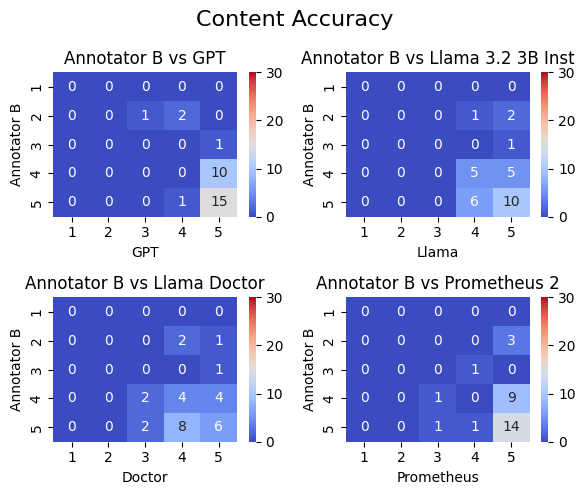

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

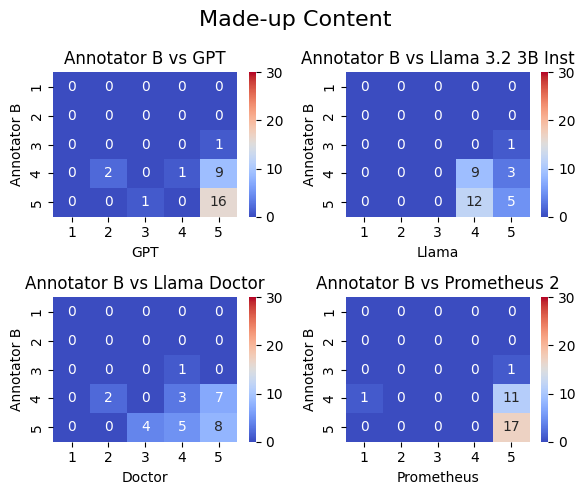

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

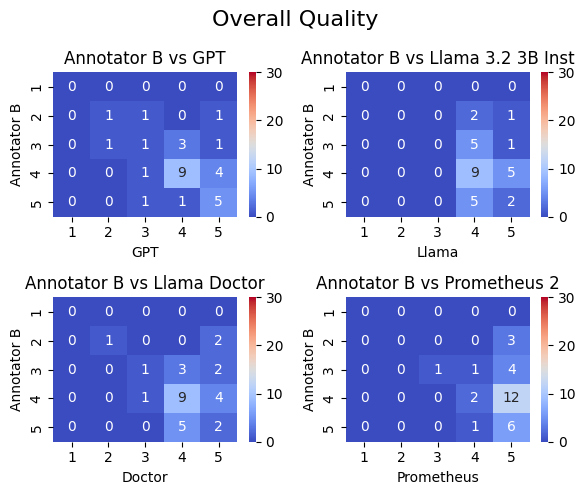

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [9]:
ls_cols = df_sc_human_laura.columns.tolist()
ls_cols.remove("filenameid")

annotator = "Annotator B"

for col in ls_cols:
    plot_agreement_heatmap(annotator, col, figsize=(6, 5))

/scratch/tmp/ipykernel_4126149/3373706943.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 2, figsize=figsize)


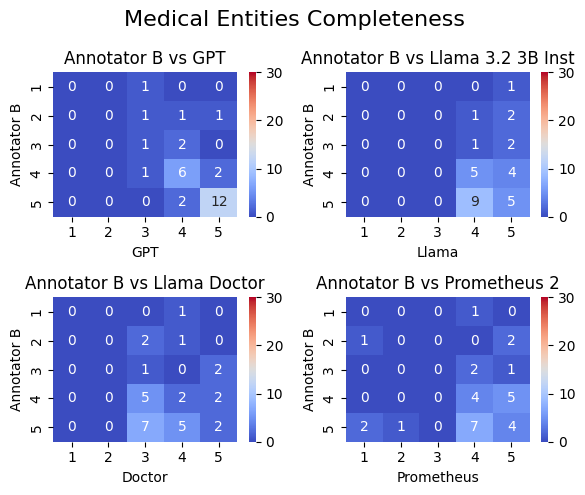

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

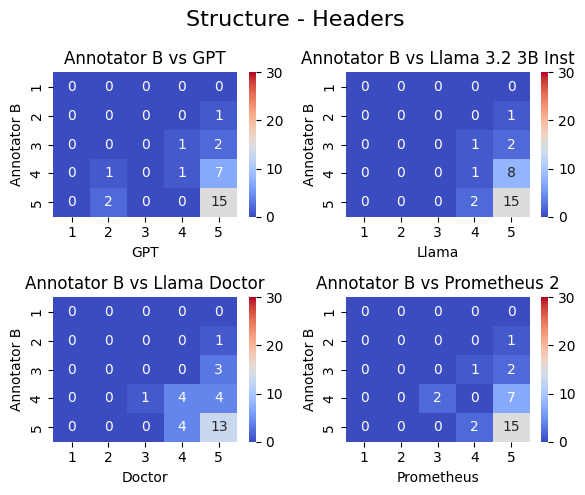

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

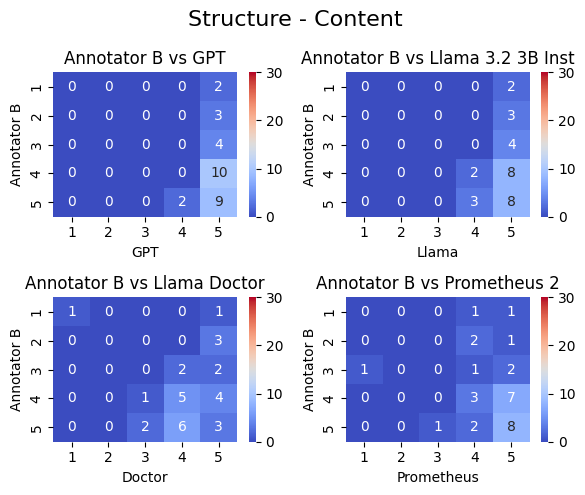

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

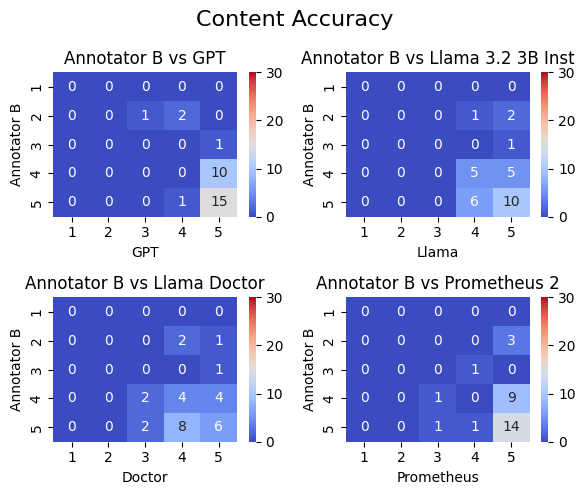

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

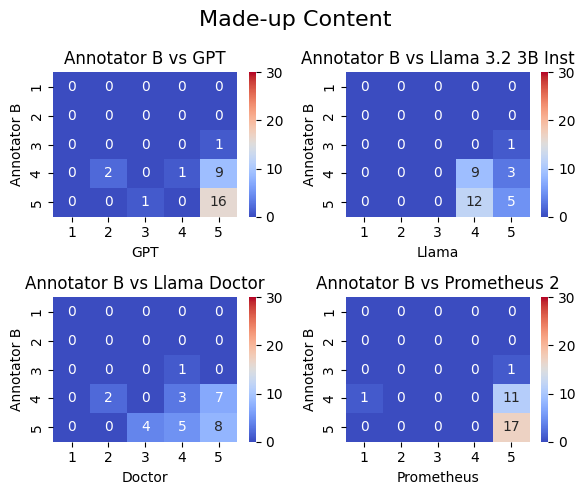

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

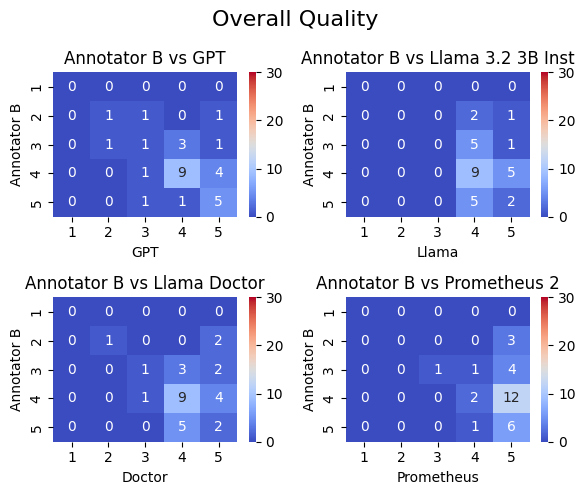

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [10]:
ls_cols = df_sc_human_laura.columns.tolist()
ls_cols.remove("filenameid")

annotator = "Annotator B"

for col in ls_cols:
    plot_agreement_heatmap(annotator, col, figsize=(6, 5))

In [11]:
field = "scores_Medical Entities Completeness"

df_agreements = pd.DataFrame()
for field in ls_cols:
    ls_pairs = [("Annotator A", "gpt"), ("Annotator A", "llama"), ("Annotator A", "doctor"), ("Annotator A", "prometheus"),
                ("Annotator B", "gpt"), ("Annotator B", "llama"), ("Annotator B", "doctor"), ("Annotator B", "prometheus")]
    d_agreements = {"Annotator A": {}, "Annotator B": {}}
    for annotator1, annotator2 in ls_pairs:
        n_agg = compute_agreement(annotator1, annotator2, field).values.diagonal().sum()
        
        d_agreements[f"{annotator1}"][f"{annotator2}"] = n_agg
        
    df_i = pd.DataFrame(d_agreements).T
    df_i["field"] = field.split("_")[1]
    
    df_agreements = pd.concat([df_agreements, df_i], axis=0)
    
df_agreements = df_agreements.reset_index()

In [12]:
df_agreements.set_index("field", inplace=True)

In [13]:
df_agreements_ann_A = df_agreements.loc[df_agreements["index"] == "Annotator A"].drop(columns=["index"])
df_agreements_ann_B = df_agreements.loc[df_agreements["index"] == "Annotator B"].drop(columns=["index"])

df_agreements_ann_A

,gpt,llama,doctor,prometheus
field,,,,
Medical Entities Completeness,21,10,4,10
Structure - Headers,17,20,16,16
Structure - Content,15,14,10,18
Content Accuracy,13,9,8,13
Made-up Content,4,20,10,4
Overall Quality,10,12,9,4


In [14]:
df_agreements_ann_A.apply(lambda x: x == x.max(), axis=1).sum(axis=0)

gpt           2
llama         3
doctor        0
prometheus    2
dtype: int64

In [15]:
df_agreements_ann_B.apply(lambda x: x == x.max(), axis=1).sum(axis=0)

gpt           4
llama         1
doctor        1
prometheus    2
dtype: int64

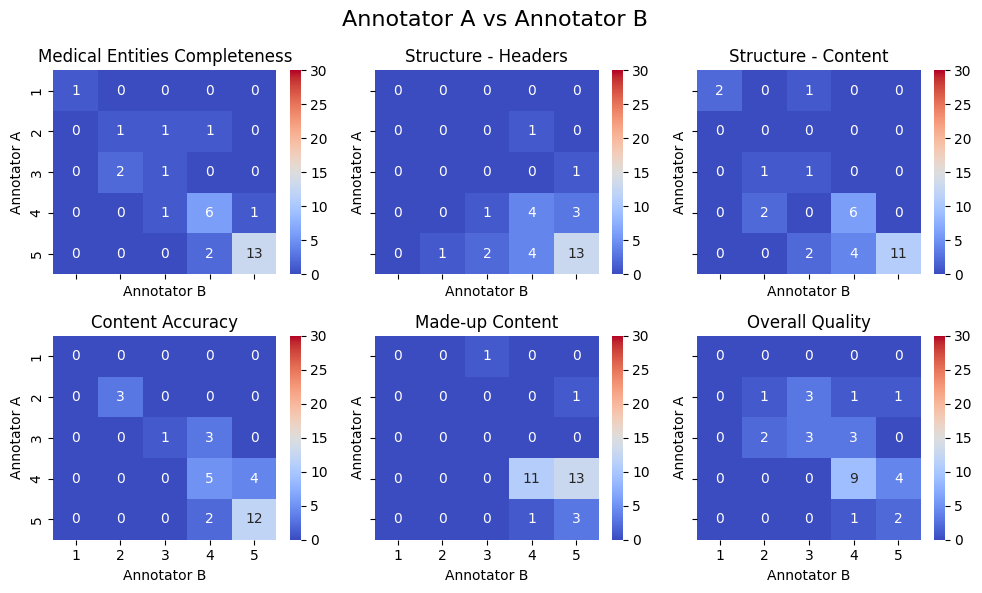

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [16]:
field = "scores_Medical Entities Completeness"

def plot_agreement_heatmap_annotators(annotator1, annotator2, field, figsize):
    
    # Plot both in a subplot
    fig, axs = plt.subplots(2, 3, figsize=figsize, sharex=True, sharey=True)
    axs = axs.flatten()
    for i, field in enumerate(ls_cols):
        df_ag_ann1_ann2 = compute_agreement(annotator1, annotator2, field)
        # df_ag_ann_llama = compute_agreement(annotator, "llama", field)
        # df_ag_ann_doctor = compute_agreement(annotator, "doctor", field)
        # df_ag_ann_prometheus = compute_agreement(annotator, "prometheus", field)


        # axs = axs.flatten()
        field_name = field.split("_")[1]

        plot_heatmap(df_ag_ann1_ann2, vmin=0, vmax=30, xlabel=annotator2, y_label=annotator1, title=f"{field_name}", fmt=".0f", ax=axs[i]);
        # plot_heatmap(df_ag_ann_llama, vmin=0, vmax=30, xlabel="Llama", y_label=annotator, title=f"{annotator} vs Llama 3.2 3B Inst", fmt=".0f", ax=axs[1]);
        # plot_heatmap(df_ag_ann_doctor, vmin=0, vmax=30, xlabel="Doctor", y_label=annotator, title=f"{annotator} vs Llama Doctor", fmt=".0f", ax=axs[2]);
        # plot_heatmap(df_ag_ann_prometheus, vmin=0, vmax=30, xlabel="Prometheus", y_label=annotator, title=f"{annotator} A vs Prometheus 2", fmt=".0f", ax=axs[3]);

        # fig.suptitle(field_name, fontsize=16)
        # fig.tight_layout();

        # field_name_filename = field_name.replace(" ", "_").replace("-", "_")
    annotator1_filename = annotator1.replace(" ", "_").replace("-", "_")
    annotator2_filename = annotator2.replace(" ", "_").replace("-", "_")
    fig.suptitle(f"{annotator1} vs {annotator2}", fontsize=16)
    fig.tight_layout();
    
    fig.savefig(f"img/results_analysis/heatmap_agreement_{annotator1_filename}_{annotator2_filename}.png", dpi=300, bbox_inches='tight')
    

# for col in ls_cols:
plot_agreement_heatmap_annotators("Annotator A", "Annotator B", col, figsize=(10, 6))

In [17]:
df_human["scores"][0]

{'Medical Entities Completeness': 5,
 'Structure - Headers': 5,
 'Structure - Content': 5,
 'Content Accuracy': 5,
 'Made-up Content': 5,
 'Overall Quality': 5}

In [18]:
df_sc_human_laura

,filenameid,scores_Medical Entities Completeness,scores_Structure - Headers,scores_Structure - Content,scores_Content Accuracy,scores_Made-up Content,scores_Overall Quality
0,27198691,5,5,5,5,5,5
1,29399767,5,5,5,4,4,4
2,29877258,4,5,5,3,1,3
3,29899452_1,4,3,3,3,2,2
4,30170386,5,4,5,4,4,2
5,30567249,5,4,5,5,4,3
6,30633184,5,5,5,5,5,4
7,30700635,5,5,5,5,4,4
8,30971480_1,5,5,5,5,4,4
9,31056078,2,2,1,3,4,2


In [19]:
d_agreements

{'Annotator A': {'gpt': 10, 'llama': 12, 'doctor': 9, 'prometheus': 4},
 'Annotator B': {'gpt': 16, 'llama': 11, 'doctor': 13, 'prometheus': 9}}

In [20]:
compute_agreement(annotator1, annotator2, field)

,1,2,3,4,5
1,0,0,0,1,0
2,1,0,0,0,2
3,0,0,0,2,1
4,0,0,0,4,5
5,2,1,0,7,4


In [21]:
d_agreements = {}
annotator1 = "Annotator A"
annotator2 = "Annotator B"
for field in ls_cols:
    # ls_pairs = [("Annotator A", "Annotator B")]
    n_agg = compute_agreement(annotator1, annotator2, field).values.diagonal().sum()
    d_agreements[field] = n_agg
        
    # df_i = pd.DataFrame(d_agreements).T
    # df_i["field"] = field.split("_")[1]
    
df_ann_agreements = pd.DataFrame(d_agreements, index=[0]).T.reset_index().rename(columns={"index": "field", 0: "agreement"})

df_ann_agreements["Percentage"] = df_ann_agreements["agreement"] / 30 * 100
d_kappa_ann = compute_kappa("Annotator A", "Annotator B", weights=None)
d_kappa_ann_weighted = compute_kappa("Annotator A", "Annotator B", weights="linear")
df_ann_agreements["Kappa"] = df_ann_agreements["field"].map(d_kappa_ann)
df_ann_agreements["Kappa weighted"] = df_ann_agreements["field"].map(d_kappa_ann_weighted)
df_ann_agreements["field"] = df_ann_agreements["field"].apply(lambda x: x.split("_")[1])

df_ann_agreements

,field,agreement,Percentage,Kappa,Kappa weighted
0,Medical Entities Completeness,22,73.333333,0.599332,0.739884
1,Structure - Headers,17,56.666667,0.194215,0.125767
2,Structure - Content,20,66.666667,0.515347,0.606643
3,Content Accuracy,21,70.000000,0.528796,0.695946
4,Made-up Content,14,46.666667,0.117647,0.149254
5,Overall Quality,15,50.000000,0.286846,0.419355


In [22]:
d_agreements = {}
annotator1 = "Annotator A"
# annotator2 = "Annotator B"

for annotator2 in ["gpt", "llama", "doctor", "prometheus"]:
    for field in ls_cols:
        # ls_pairs = [("Annotator A", "Annotator B")]
        n_agg = compute_agreement(annotator1, annotator2, field).values.diagonal().sum()
        d_agreements[field] = n_agg
            
        # df_i = pd.DataFrame(d_agreements).T
        # df_i["field"] = field.split("_")[1]
        
    df_ann_agreements = pd.DataFrame(d_agreements, index=[0]).T.reset_index().rename(columns={"index": "field", 0: "agreement"})

    df_ann_agreements["Percentage"] = df_ann_agreements["agreement"] / 30 * 100
    d_kappa_ann = compute_kappa(annotator1, annotator2, weights=None)
    d_kappa_ann_weighted = compute_kappa(annotator1, annotator2, weights="linear")
    df_ann_agreements["Kappa"] = df_ann_agreements["field"].map(d_kappa_ann)
    df_ann_agreements["Kappa weighted"] = df_ann_agreements["field"].map(d_kappa_ann_weighted)
    df_ann_agreements["field"] = df_ann_agreements["field"].apply(lambda x: x.split("_")[1])

    print(f"Agreement {annotator1} vs {annotator2}")
    print(df_ann_agreements.to_latex(index=False, float_format="%.4f", escape=False))
    print("\n")

Agreement Annotator A vs gpt
\begin{tabular}{lrrrr}
\toprule
field & agreement & Percentage & Kappa & Kappa weighted \\
\midrule
Medical Entities Completeness & 21 & 70.0000 & 0.5304 & 0.5881 \\
Structure - Headers & 17 & 56.6667 & -0.0236 & 0.1030 \\
Structure - Content & 15 & 50.0000 & -0.1029 & -0.0714 \\
Content Accuracy & 13 & 43.3333 & -0.0099 & 0.1244 \\
Made-up Content & 4 & 13.3333 & -0.0130 & -0.0494 \\
Overall Quality & 10 & 33.3333 & 0.0826 & 0.1617 \\
\bottomrule
\end{tabular}



Agreement Annotator A vs llama
\begin{tabular}{lrrrr}
\toprule
field & agreement & Percentage & Kappa & Kappa weighted \\
\midrule
Medical Entities Completeness & 10 & 33.3333 & -0.0676 & -0.1481 \\
Structure - Headers & 20 & 66.6667 & 0.1379 & 0.0930 \\
Structure - Content & 14 & 46.6667 & -0.1034 & -0.0946 \\
Content Accuracy & 9 & 30.0000 & -0.1667 & -0.1111 \\
Made-up Content & 20 & 66.6667 & 0.1667 & 0.1026 \\
Overall Quality & 12 & 40.0000 & 0.1000 & 0.0728 \\
\bottomrule
\end{tabular}



Ag

In [23]:
d_agreements = {}
annotator1 = "Annotator B"
# annotator2 = "Annotator B"

for annotator2 in ["gpt", "llama", "doctor", "prometheus"]:
    for field in ls_cols:
        # ls_pairs = [("Annotator A", "Annotator B")]
        n_agg = compute_agreement(annotator1, annotator2, field).values.diagonal().sum()
        d_agreements[field] = n_agg
            
        # df_i = pd.DataFrame(d_agreements).T
        # df_i["field"] = field.split("_")[1]
        
    df_ann_agreements = pd.DataFrame(d_agreements, index=[0]).T.reset_index().rename(columns={"index": "field", 0: "agreement"})

    df_ann_agreements["Percentage"] = df_ann_agreements["agreement"] / 30 * 100
    d_kappa_ann = compute_kappa(annotator1, annotator2, weights=None)
    d_kappa_ann_weighted = compute_kappa(annotator1, annotator2, weights="linear")
    df_ann_agreements["Kappa"] = df_ann_agreements["field"].map(d_kappa_ann)
    df_ann_agreements["Kappa weighted"] = df_ann_agreements["field"].map(d_kappa_ann_weighted)
    df_ann_agreements["field"] = df_ann_agreements["field"].apply(lambda x: x.split("_")[1])

    print(f"Agreement {annotator1} vs {annotator2}")
    print(df_ann_agreements.to_latex(index=False, float_format="%.4f", escape=False))
    print("\n")

Agreement Annotator B vs gpt
\begin{tabular}{lrrrr}
\toprule
field & agreement & Percentage & Kappa & Kappa weighted \\
\midrule
Medical Entities Completeness & 19 & 63.3333 & 0.4301 & 0.4851 \\
Structure - Headers & 16 & 53.3333 & 0.0749 & 0.0282 \\
Structure - Content & 9 & 30.0000 & -0.1014 & -0.0735 \\
Content Accuracy & 15 & 50.0000 & 0.0066 & 0.1818 \\
Made-up Content & 17 & 56.6667 & 0.1236 & 0.1207 \\
Overall Quality & 16 & 53.3333 & 0.3126 & 0.3764 \\
\bottomrule
\end{tabular}



Agreement Annotator B vs llama
\begin{tabular}{lrrrr}
\toprule
field & agreement & Percentage & Kappa & Kappa weighted \\
\midrule
Medical Entities Completeness & 10 & 33.3333 & -0.0714 & -0.1139 \\
Structure - Headers & 16 & 53.3333 & 0.0047 & 0.0288 \\
Structure - Content & 10 & 33.3333 & -0.0435 & -0.0693 \\
Content Accuracy & 15 & 50.0000 & 0.0854 & 0.0367 \\
Made-up Content & 14 & 46.6667 & 0.0303 & -0.0119 \\
Overall Quality & 11 & 36.6667 & -0.0497 & -0.0084 \\
\bottomrule
\end{tabular}



Agre

In [24]:
ls_llms = ["gpt", "llama", "doctor", "prometheus"]

d_multi_kappa_total = {}
for llm in ls_llms: 
    ls_names = ["Annotator A", "Annotator B", llm]
    d_multi_kappa = compute_multi_kappa(d_dataframes, ls_names, ls_cols)
    d_multi_kappa_total[llm] = d_multi_kappa

# df_multi_kappa["field"] = df_multi_kappa["field"].apply(lambda x: x.split("_")[1])
# df_multi_kappa = df_multi_kappa.reset_index(drop=True)

df_multi_kappa_total = pd.DataFrame(d_multi_kappa_total)
df_multi_kappa_total.index = df_multi_kappa_total.index.str.split("_").str[1]
df_multi_kappa_total["Metric mean"] = df_multi_kappa_total.mean(axis=1)
df_multi_kappa_total.loc["Model mean", :] = df_multi_kappa_total.mean(axis=0)

print(df_multi_kappa_total.to_latex(index=True, float_format="%.4f", escape=False))
df_multi_kappa_total

\begin{tabular}{lrrrrr}
\toprule
 & gpt & llama & doctor & prometheus & Metric mean \\
\midrule
Medical Entities Completeness & 0.5208 & 0.1633 & 0.1070 & 0.1671 & 0.2395 \\
Structure - Headers & 0.0902 & 0.1148 & 0.1222 & 0.0308 & 0.0895 \\
Structure - Content & 0.1370 & 0.1529 & 0.1491 & 0.2824 & 0.1803 \\
Content Accuracy & 0.1966 & 0.1589 & 0.1141 & 0.1845 & 0.1635 \\
Made-up Content & 0.0620 & 0.0994 & 0.0288 & 0.0484 & 0.0597 \\
Overall Quality & 0.2247 & 0.1206 & 0.1335 & 0.0966 & 0.1439 \\
Model mean & 0.2052 & 0.1350 & 0.1091 & 0.1350 & 0.1461 \\
\bottomrule
\end{tabular}



,gpt,llama,doctor,prometheus,Metric mean
Medical Entities Completeness,0.520821,0.163277,0.106963,0.167129,0.239548
Structure - Headers,0.090220,0.114833,0.122165,0.030769,0.089497
Structure - Content,0.136961,0.152855,0.149055,0.282380,0.180313
Content Accuracy,0.196604,0.158879,0.114071,0.184466,0.163505
Made-up Content,0.061967,0.099357,0.028840,0.048443,0.059652
Overall Quality,0.224684,0.120631,0.133515,0.096649,0.143870
Model mean,0.205209,0.134972,0.109101,0.134973,0.146064


In [25]:
ls_llms = ["prometheus", "llama", "doctor", "gpt"]

ls_names = ["Annotator A", "Annotator B"] + ls_llms
d_multi_kappa_comb = compute_multi_kappa(d_dataframes, ls_names, ls_cols)


# df_multi_kappa["field"] = df_multi_kappa["field"].apply(lambda x: x.split("_")[1])
# df_multi_kappa = df_multi_kappa.reset_index(drop=True)

# pd.DataFrame(d_multi_kappa_comb)

d_multi_kappa_comb


{'scores_Medical Entities Completeness': 0.05764355780888351,
 'scores_Structure - Headers': 0.03538710256870821,
 'scores_Structure - Content': 0.02515295717199156,
 'scores_Content Accuracy': -0.024730154392676413,
 'scores_Made-up Content': 0.03445664521014754,
 'scores_Overall Quality': 0.10512791866830513}

In [26]:
print(df_ann_agreements.to_latex())

\begin{tabular}{llrrrr}
\toprule
 & field & agreement & Percentage & Kappa & Kappa weighted \\
\midrule
0 & Medical Entities Completeness & 8 & 26.666667 & -0.100000 & -0.067308 \\
1 & Structure - Headers & 15 & 50.000000 & -0.018100 & 0.056291 \\
2 & Structure - Content & 11 & 36.666667 & 0.042017 & 0.069767 \\
3 & Content Accuracy & 14 & 46.666667 & -0.038961 & -0.011730 \\
4 & Made-up Content & 17 & 56.666667 & 0.041769 & 0.062500 \\
5 & Overall Quality & 9 & 30.000000 & 0.049774 & 0.052953 \\
\bottomrule
\end{tabular}



In [27]:
print(df_agreements_ann_B.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & gpt & llama & doctor & prometheus \\
field &  &  &  &  \\
\midrule
Medical Entities Completeness & 19 & 10 & 5 & 8 \\
Structure - Headers & 16 & 16 & 17 & 15 \\
Structure - Content & 9 & 10 & 9 & 11 \\
Content Accuracy & 15 & 15 & 10 & 14 \\
Made-up Content & 17 & 14 & 11 & 17 \\
Overall Quality & 16 & 11 & 13 & 9 \\
\bottomrule
\end{tabular}

